Sampling: [alpha_raw, beta_raw, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_raw, beta_raw]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 72 seconds.


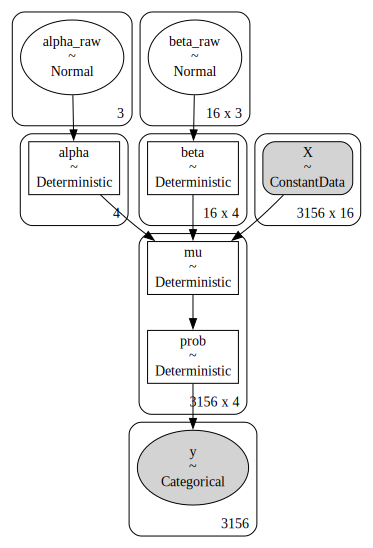

In [419]:

cracker_choice_short = pd.read_csv('../data/cracker_choice_short.csv')
temp = pd.concat([cracker_choice_short, pd.get_dummies(cracker_choice_short['lastChoice'], prefix='last_choice')], axis=1)
y_s = pd.Categorical(temp['choice']).codes

x_n = ['disp.sunshine', 'disp.keebler',
       'disp.nabisco', 'disp.private', 'feat.sunshine', 'feat.keebler',
       'feat.nabisco', 'feat.private', 'price.sunshine', 'price.keebler',
       'price.nabisco', 'price.private', 'last_choice_keebler',
       'last_choice_nabisco', 'last_choice_private', 'last_choice_sunshine']
       
x_s = temp[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)

x_s.shape, y_s.shape, np.unique(y_s)


alternatives = 3
vars = len(x_n)
with pm.Model() as model:
    alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
    beta_raw = pm.Normal('beta_raw', 0, .5, size=(vars, alternatives))

    alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))
    beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))

    X = pm.Data('X', x_s)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(X, beta))

    prob = pm.Deterministic('prob', pt.special.softmax(mu, axis=1))

    y = pm.Categorical('y', p=prob, observed=y_s)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(1000, tune=2000, random_seed=199))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)



In [422]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

## Fake Data and Modelling Utility

In [12]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor.tensor as pt 
import arviz as az


np.random.seed(100)
def softmax(x): 
    return np.exp(x)/sum(np.exp(x))

def create_probs(P=10):
    # Create a random characteristic matrix and weights matrix X and beta
    X = np.random.normal(0, 1, size=(P, 5))
    beta = np.random.normal(0, 1, size=5)
    # Draw some random demand shocks for each product
    xi = np.random.normal(0, 1, size=P)
    # Generate the fixed utilities
    mu = np.dot(X, beta) + xi
    # illustrate the probabilities
    probs = softmax(mu)
    return probs, mu

probs, mu = create_probs(P=11)

pd.DataFrame({'probs': np.round(probs*100, 2), 
              'cumulative_prod': np.cumsum(probs)})

,probs,cumulative_prod
0,1.10,0.011005
1,1.12,0.022214
2,0.83,0.030493
3,74.36,0.774142
4,0.38,0.777893
5,7.79,0.855797
6,6.47,0.920453
7,1.16,0.932013
8,6.06,0.992627
9,0.54,0.997985


In [13]:
def simulate_data(P, mu, N_customers=100):
  # Variable sizes
  N_choices = (P+1) * N_customers
  # Probabilities including outside good
  probs = softmax(np.concatenate([[0], mu]))
  simulated_data = pd.DataFrame({'choice': np.zeros(N_choices),
                              'customer_id':  np.repeat(range(0, N_customers), [P+1], axis=0),
                              'product': list(range(0, P+1))*N_customers
                              })
  # Draw a choice and indicate this with choice = 1; all unchosen 
  # products remain with choice = 0
  for i in range(0, N_customers):
    choice = np.random.choice(range(0,(P+1)), size = 1, p=probs)[0]
    simulated_data.loc[(simulated_data['customer_id'] == i) & (simulated_data['product'] == choice), 'choice'] = 1

  return simulated_data

simulated_data = simulate_data(len(probs), mu)
simulated_data

,choice,customer_id,product
0,0.0,0,0
1,0.0,0,1
2,0.0,0,2
3,0.0,0,3
4,1.0,0,4
...,...,...,...
1195,0.0,99,7
1196,0.0,99,8
1197,0.0,99,9
1198,0.0,99,10


In [14]:
temp = pd.concat([simulate_data(len(probs), mu) for i in range(3)])
repeat_sales = (temp.query('choice == 1.0').reset_index(drop=True).sort_values('customer_id').reset_index(drop=True))
repeat_sales



,choice,customer_id,product
0,1.0,0,9
1,1.0,0,4
2,1.0,0,4
3,1.0,1,9
4,1.0,1,4
...,...,...,...
295,1.0,98,0
296,1.0,98,4
297,1.0,99,4
298,1.0,99,4


Text(0.5, 1.0, 'True Share')

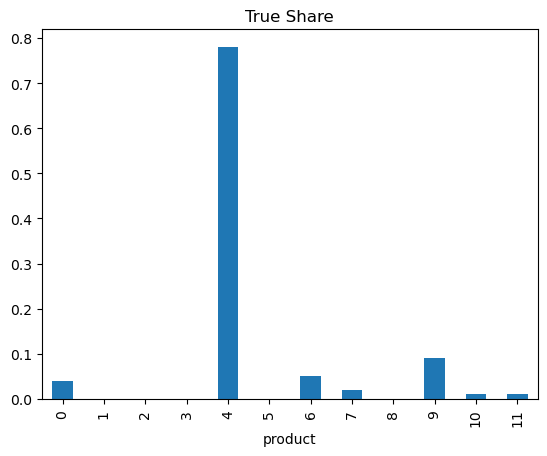

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
(simulated_data.groupby('product').apply(lambda x: np.sum(x['choice'])/100).
plot.bar(ax=ax))
ax.set_title("True Share")

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/data.py:427: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: [alpha_raw, beta_raw, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_raw, beta_raw]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


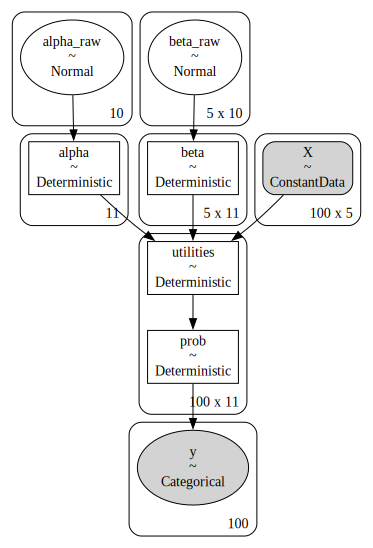

In [16]:
alternatives = 10
vars = 5
df  = (simulated_data.groupby(['customer_id', 'choice']).max(['product']).
reset_index().query('choice == 1.0').reset_index(drop=True))
X = pd.DataFrame(np.random.normal(0, 1, size=(100, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([df, X], axis=1)
y_s = pd.Categorical(df['product']).codes


with pm.Model() as model:
    alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
    beta_raw = pm.Normal('beta_raw', 0, .5, size=(vars, alternatives))

    alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))
    beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))

    X = pm.Data('X', df[['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']])
    utilities = pm.Deterministic('utilities', alpha + pm.math.dot(X, beta))

    prob = pm.Deterministic('prob', pt.special.softmax(utilities, axis=1))

    y = pm.Categorical('y', p=prob, observed=y_s)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(1000, tune=2000, random_seed=199))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)


In [17]:
az.summary(idata)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_raw[0],3.677,0.373,2.983,4.374,0.008,0.006,2339.0,2754.0,1.0
alpha_raw[1],0.147,0.574,-0.898,1.302,0.010,0.008,3077.0,2556.0,1.0
alpha_raw[2],-0.430,0.659,-1.606,0.834,0.010,0.010,4307.0,2266.0,1.0
alpha_raw[3],1.110,0.481,0.139,1.944,0.009,0.006,3073.0,2992.0,1.0
alpha_raw[4],-0.773,0.691,-2.113,0.496,0.011,0.009,4310.0,3039.0,1.0
...,...,...,...,...,...,...,...,...,...
"prob[99, 6]",0.013,0.014,0.000,0.038,0.000,0.000,5876.0,3084.0,1.0
"prob[99, 7]",0.010,0.011,0.000,0.028,0.000,0.000,5406.0,2901.0,1.0
"prob[99, 8]",0.009,0.011,0.000,0.028,0.000,0.000,5551.0,2989.0,1.0
"prob[99, 9]",0.009,0.011,0.000,0.029,0.000,0.000,6556.0,3153.0,1.0


<Axes: xlabel='y / y'>

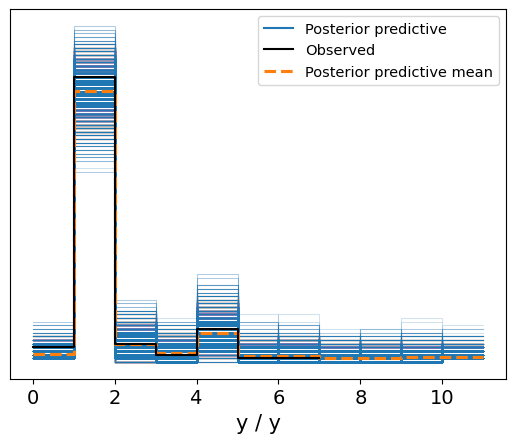

In [18]:
az.plot_ppc(idata)

In [19]:
az.extract(idata.posterior.prob).mean(dim='prob_dim_0').mean(dim='sample')

<xarray.Dataset>
Dimensions:     (prob_dim_1: 11)
Coordinates:
  * prob_dim_1  (prob_dim_1) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    prob        (prob_dim_1) float64 0.02263 0.7429 0.0487 ... 0.01211 0.01195

## Adding Subject Specific Utilities



In [20]:
repeat_sales

,choice,customer_id,product
0,1.0,0,9
1,1.0,0,4
2,1.0,0,4
3,1.0,1,9
4,1.0,1,4
...,...,...,...
295,1.0,98,0
296,1.0,98,4
297,1.0,99,4
298,1.0,99,4


Sampling: [alpha_raw, beta_raw, subject_alpha_raw, subject_beta_raw, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_raw, subject_alpha_raw, beta_raw, subject_beta_raw]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 69 seconds.


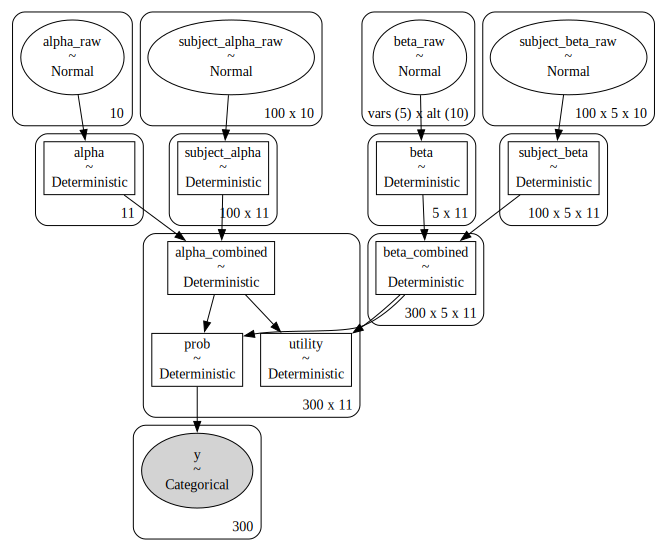

In [91]:
alternatives = 10
vars = 5
customers = 100
observations = 300
X = pd.DataFrame(np.random.normal(0, 1, size=(300, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([repeat_sales, X], axis=1)
y_s = pd.Categorical(df['product']).codes

customer_idx, uniques = pd.factorize(df['customer_id'])

coords = {'customer': customer_idx , 'vars': range(5), 'alt': range(10)}
with pm.Model(coords=coords) as model:
    alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
    alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))

    subject_alpha_raw = pm.Normal('subject_alpha_raw', 0, 1, size=(customers, alternatives))
    subject_alpha = pm.Deterministic('subject_alpha', pt.concatenate([np.zeros((customers,1)), subject_alpha_raw], axis=1))
    alpha_combined = pm.Deterministic('alpha_combined', alpha + subject_alpha[customer_idx])

    beta_raw = pm.Normal('beta_raw', 0, .5, dims=('vars', 'alt'))
    beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))
    subject_beta_raw =  pm.Normal('subject_beta_raw', 0, 1, size=(customers, vars, alternatives))
    subject_beta = pm.Deterministic('subject_beta', pt.concatenate([np.zeros((customers, vars, 1)), subject_beta_raw], axis=2))
   
    beta_combined = pm.Deterministic('beta_combined', beta + subject_beta[customer_idx])

    utilities = []
    probs = []
    for i in df['customer_id'].unique():
        X = df[df['customer_id']==i][['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']]
        utility = alpha_combined[i, :] + pm.math.dot(X, beta_combined[i, :, :])
        utilities.append(utility)
        prob = pt.special.softmax(utility, axis=1)
        probs.append(prob)
    
    utility = pm.Deterministic('utility', pt.concatenate(utilities))
    prob = pm.Deterministic('prob', pt.concatenate(probs))
    y = pm.Categorical('y', p=prob, observed=y_s)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(1000, tune=2000, random_seed=199))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)


<Axes: xlabel='y / y'>

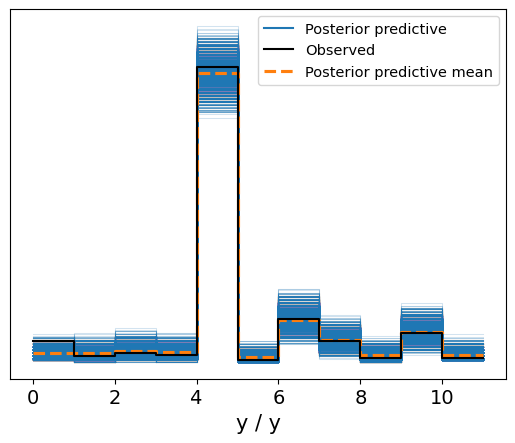

In [92]:
az.plot_ppc(idata)

In [93]:
az.summary(idata, var_names=['alpha'])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
alpha[1],-1.926,0.571,-2.956,-0.850,0.008,0.006,5534.0,3518.0,1.0
alpha[2],-1.455,0.543,-2.486,-0.494,0.007,0.005,5547.0,3586.0,1.0
alpha[3],-1.692,0.558,-2.783,-0.689,0.008,0.006,5453.0,3324.0,1.0
alpha[4],3.979,0.343,3.346,4.627,0.005,0.003,5295.0,2996.0,1.0
alpha[5],-2.485,0.625,-3.643,-1.305,0.008,0.006,6238.0,3450.0,1.0
alpha[6],0.468,0.417,-0.302,1.270,0.006,0.004,5394.0,3379.0,1.0
alpha[7],-0.556,0.472,-1.440,0.317,0.007,0.006,4902.0,3509.0,1.0
alpha[8],-2.057,0.578,-3.173,-1.021,0.007,0.005,6023.0,3261.0,1.0
alpha[9],-0.048,0.443,-0.896,0.751,0.006,0.006,5591.0,3678.0,1.0


In [94]:
az.extract(idata.posterior.prob).mean(dim='prob_dim_0').mean(dim='sample')

<xarray.Dataset>
Dimensions:     (prob_dim_1: 11)
Coordinates:
  * prob_dim_1  (prob_dim_1) int64 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    prob        (prob_dim_1) float64 0.02116 0.01954 0.02488 ... 0.06678 0.01674

In [95]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

array([<Axes: >], dtype=object)

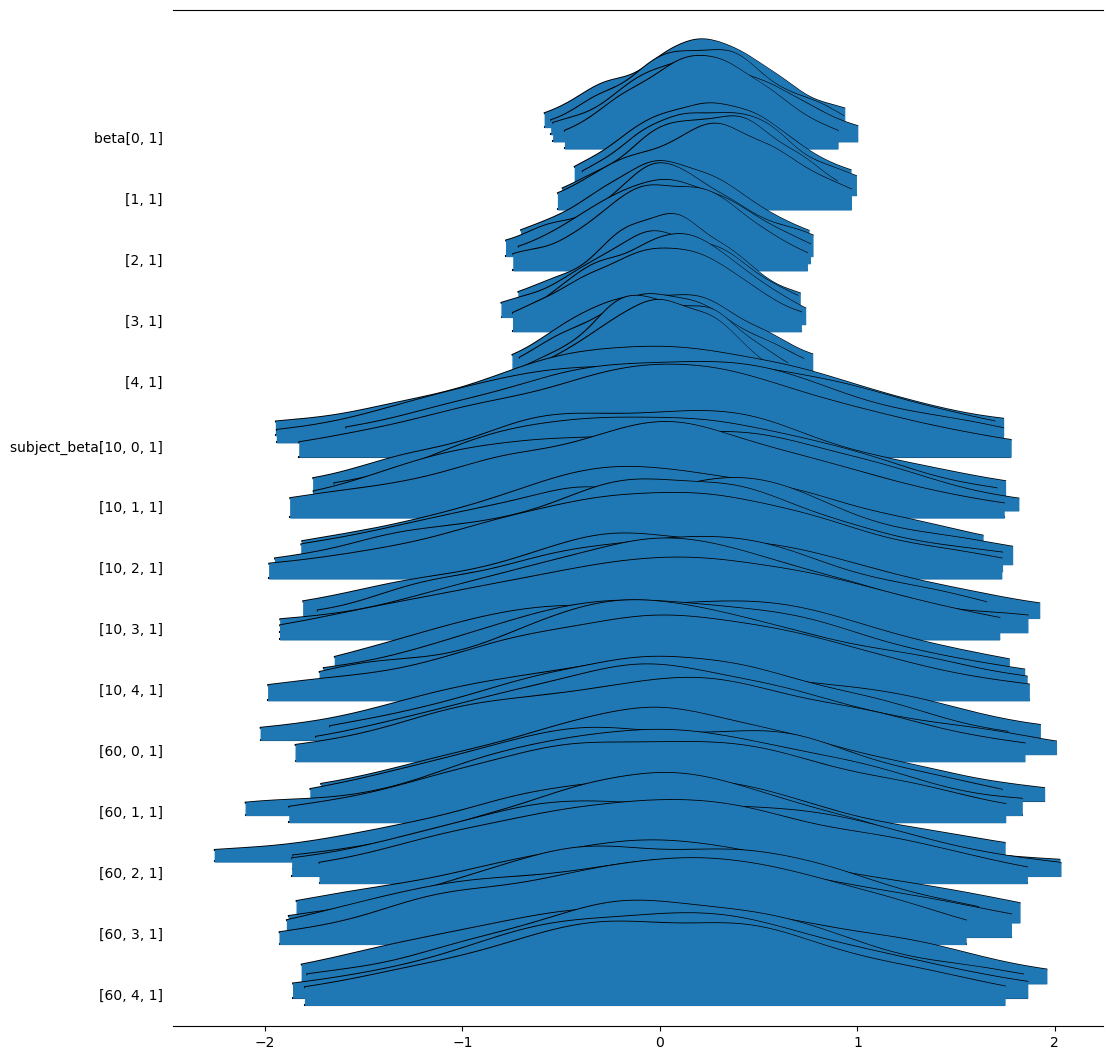

In [103]:
az.plot_forest(idata, var_names=['beta', 'subject_beta'], coords={'beta_dim_1': [1], 
'subject_beta_dim_0': [10, 60], 'subject_beta_dim_2': [1]
}, kind='ridgeplot')

### Add correlation matrix on Betas

Sampling: [alpha_raw, beta_raw_, chol, subject_alpha_raw, subject_beta_raw, y]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:07.574211
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time =  0:27:44.912357
Transforming variables...


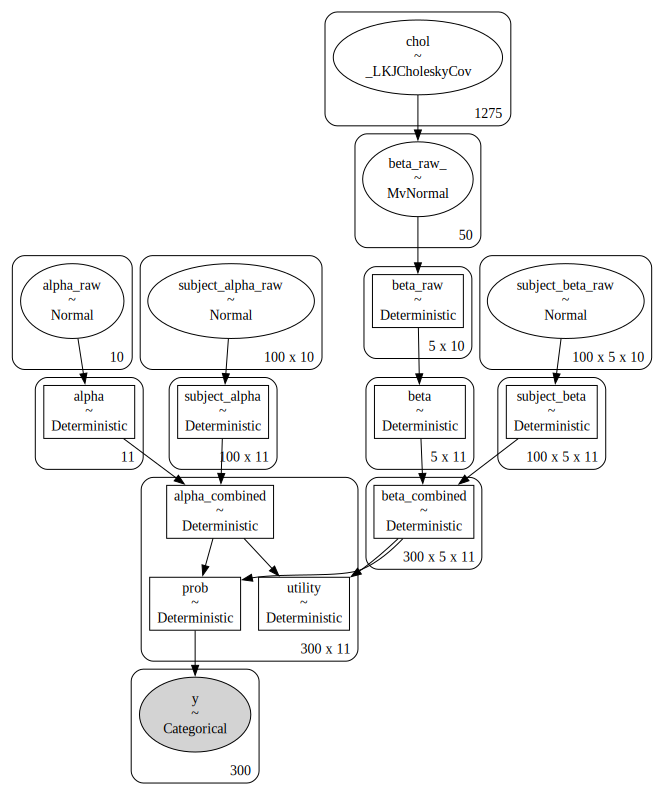

In [203]:
alternatives = 10
vars = 5
customers = 100
observations = 300
X = pd.DataFrame(np.random.normal(0, 1, size=(300, 5)), columns=[f'feat_{i}' for i in range(5)])
df = pd.concat([repeat_sales, X], axis=1)
y_s = pd.Categorical(df['product']).codes

customer_idx, uniques = pd.factorize(df['customer_id'])
alt_indx = list(range(10))

coords = {'customer': customer_idx , 'vars': range(5), 'alt': range(10)}
with pm.Model(coords=coords) as model:
    alpha_raw = pm.Normal('alpha_raw', 0, 1, size=alternatives)
    alpha = pm.Deterministic('alpha', pt.concatenate([[0], alpha_raw]))

    subject_alpha_raw = pm.Normal('subject_alpha_raw', 0, 1, size=(customers, alternatives))
    subject_alpha = pm.Deterministic('subject_alpha', pt.concatenate([np.zeros((customers,1)), subject_alpha_raw], axis=1))
    alpha_combined = pm.Deterministic('alpha_combined', alpha + subject_alpha[customer_idx])

    packed_chol = pm.LKJCholeskyCov(
        'chol', n=50, eta=4.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=False,
        )
    chol = pm.expand_packed_triangular(50, packed_chol, lower=True)
    beta_raw = pm.MvNormal('beta_raw_', mu=np.zeros(50), chol=chol)

    beta_raw = pm.Deterministic('beta_raw', beta_raw.reshape((5, 10)))
    beta = pm.Deterministic('beta', pt.concatenate([np.zeros((vars, 1)), beta_raw], axis=1))
    
    subject_beta_raw =  pm.Normal('subject_beta_raw', 0, 1, size=(customers, vars, alternatives))
    subject_beta = pm.Deterministic('subject_beta', pt.concatenate([np.zeros((customers, vars, 1)), subject_beta_raw], axis=2))
   
    beta_combined = pm.Deterministic('beta_combined', beta + subject_beta[customer_idx])

    utilities = []
    probs = []
    for i in df['customer_id'].unique():
        X = df[df['customer_id']==i][['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4']]
        utility = alpha_combined[i, :] + pm.math.dot(X, beta_combined[i, :, :])
        utilities.append(utility)
        prob = pt.special.softmax(utility, axis=1)
        probs.append(prob)
    
    utility = pm.Deterministic('utility', pt.concatenate(utilities))
    prob = pm.Deterministic('prob', pt.concatenate(probs))
    y = pm.Categorical('y', p=prob, observed=y_s)
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(nuts_sampler='numpyro', draws=1000, tune=2000, random_seed=199))
    idata.extend(pm.sample_posterior_predictive(idata))

pm.model_to_graphviz(model)

<Axes: >

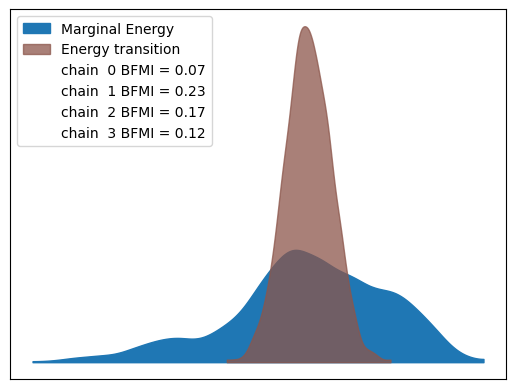

In [204]:
az.plot_energy(idata)

In [206]:
az.summary(idata, var_names=['beta'])

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
"beta[0, 1]",-0.016,0.352,-0.778,0.631,0.017,0.013,583.0,231.0,1.02
"beta[0, 2]",0.011,0.331,-0.659,0.650,0.015,0.010,450.0,496.0,1.01
"beta[0, 3]",-0.180,0.407,-1.088,0.473,0.027,0.019,240.0,224.0,1.02
"beta[0, 4]",-0.079,0.246,-0.606,0.343,0.015,0.011,288.0,324.0,1.02
"beta[0, 5]",-0.004,0.404,-0.858,0.773,0.019,0.014,409.0,490.0,1.02
"beta[0, 6]",-0.038,0.248,-0.481,0.493,0.011,0.008,464.0,1162.0,1.01
"beta[0, 7]",-0.495,0.455,-1.440,0.182,0.046,0.033,113.0,188.0,1.04
"beta[0, 8]",-0.228,0.452,-1.193,0.520,0.029,0.021,295.0,332.0,1.02
"beta[0, 9]",0.020,0.318,-0.551,0.693,0.016,0.014,379.0,177.0,1.01


<Axes: xlabel='y / y'>

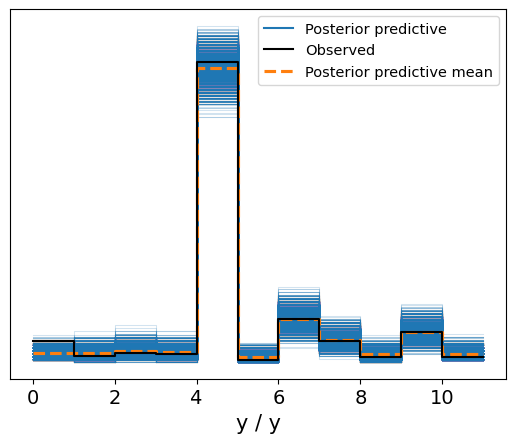

In [207]:
az.plot_ppc(idata)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

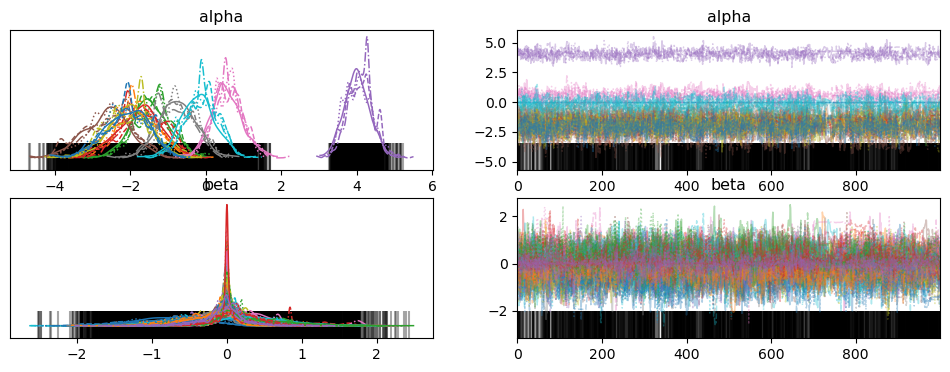

In [208]:
az.plot_trace(idata, var_names=['alpha', 'beta'])